<a href="https://colab.research.google.com/github/JaymeNeto/nlp-tweets-disaster-detection/blob/master/nlp_with_Tensorflow.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
'''for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))'''

# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

"for dirname, _, filenames in os.walk('/kaggle/input'):\n    for filename in filenames:\n        print(os.path.join(dirname, filename))"

In [3]:
print('Loading word vectors...')
word2vec = {}
with open(os.path.join('/content/drive/My Drive/Notebooks/Kaggle/nlp-tweets-disaster/glove.twitter.27B.200d.txt'), encoding = "utf-8") as f:
  # is just a space-separated text file in the format:
  # word vec[0] vec[1] vec[2] ...
    for line in f:
        values = line.split() #split at space
        word = values[0]
        vec = np.asarray(values[1:], dtype='float32') #numpy.asarray()function is used when we want to convert input to an array.
        word2vec[word] = vec
print('Found %s word vectors.' % len(word2vec))

Loading word vectors...
Found 1193514 word vectors.


In [4]:
import pandas as pd
train_df = pd.read_csv('/content/drive/My Drive/Notebooks/Kaggle/nlp-tweets-disaster/train.csv')
test_df = pd.read_csv('/content/drive/My Drive/Notebooks/Kaggle/nlp-tweets-disaster/test.csv')
train_df.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [5]:
train_df.isnull().sum()

id             0
keyword       61
location    2533
text           0
target         0
dtype: int64

In [6]:
import pandas as pd
import numpy as np

import re
import nltk
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from nltk.tokenize import word_tokenize, sent_tokenize
from nltk.stem.wordnet import WordNetLemmatizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
import string

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, f1_score

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Dense, LSTM, Embedding
from tensorflow.keras.models import Sequential
import os

nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


True

In [7]:
print(train_df.shape)
print(test_df.shape)

(7613, 5)
(3263, 4)


In [8]:
train_sentences = train_df.text.values
train_labels = train_df.target.values
test_sentences = test_df.text.values

In [9]:
train_size = len(train_sentences)
train_size

7613

In [10]:
import string
import re
punctuation = re.sub('(<|>)', '', string.punctuation)


#remove html tags
def remove_html(text):
    html=re.compile(r'<.*?>')
    return html.sub(r'',text)

#remove urls
def remove_urls(text):
    url = re.compile(r'https?://\S+|www\.\S+')
    return url.sub(r'<URL>',text)

def remove_numbers(text):
  numbers = re.compile('[-+]?[.\d]*[\d]+[:,.\d]*')
  return numbers.sub(r'<NUMBER>',text)

def remove_user(text):
  user = re.compile(r'@\w+')
  return user.sub('<USER>', text)

# splitting the text
def split_text(text):
    text = text.split()
    return text

 # making lower case words
def lower(text):
    text = [word.lower() for word in text]
    return str(text)

#remove punct
def remove_punct(text):
    text = ''.join([char for char in text if char not in punctuation])
    text = re.sub('[0-9]+', '', str(text))
    return text


#remove stopwords
def remove_stopwords(text):
    pattern = re.compile(r'\b('+r'|'.join(stopwords.words('english')) + r')\b\s*')
    text = pattern.sub(' ', text)
    return text

#lemmatization
lemmatizer = WordNetLemmatizer()
def lemmatize_words(text):
    text = lemmatizer.lemmatize(text)
    return text

In [11]:
def final(text):
    t0 = remove_html(text)
    t1 = remove_urls(t0)
    t2 = remove_user(t1)
    t3 = remove_numbers(t2)
    t4 = split_text(t3)
    t5 = lower(t4)
    t6 = remove_punct(t5)
    t7 = remove_stopwords(t6)
    t8 = lemmatize_words(t7)
    return t8

In [12]:
training_sentences = []
for i in range(len(train_sentences)):
    data = final(train_sentences[i])
    training_sentences.append(data)

testing_sentences = []
for i in range(len(test_sentences)):
    data = final(test_sentences[i])
    testing_sentences.append(data)

In [13]:
num_words = 25000
embedding_dim = 200
max_length = 32
trunc_type='post'
padding_type='post'
oov_tok = 'OOV'

tokenizer = Tokenizer(num_words=num_words, oov_token=oov_tok, filters=punctuation)
tokenizer.fit_on_texts(training_sentences)
train_sequences = tokenizer.texts_to_sequences(training_sentences)

word_index = tokenizer.word_index
padded_train = pad_sequences(sequences=train_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)

print('Total unique tokens generated: ',len(word_index))
print('Shape of padded train tensor: ', padded_train.shape)

#tokenizer = Tokenizer(num_words=num_words, oov_token=oov_tok)
#tokenizer.fit_on_texts(testing_sentences)
test_sequences = tokenizer.texts_to_sequences(testing_sentences)
padded_test = pad_sequences(sequences=test_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)

print('Shape of padded test tensor: ', padded_test.shape)

Total unique tokens generated:  15091
Shape of padded train tensor:  (7613, 32)
Shape of padded test tensor:  (3263, 32)


In [ ]:
print(training_sentences[-1], '\n', train_sequences[-1])
for word in training_sentences[-1].split():
  if word_index.get(word):
    print(word +':',word_index.get(word))

 latest  homes razed  northern california wildfire  abc news <url> 
 [116, 111, 422, 103, 27, 87, 614, 14, 2]
latest: 116
homes: 111
razed: 422
northern: 103
california: 27
wildfire: 87
abc: 614
news: 14
<url>: 2


In [ ]:
train_sequences[:5]

[[4218, 703, 150, 55, 1420, 4219, 17],
 [100, 8, 132, 568, 6291, 6292, 1216],
 [1538, 1421, 1921, 543, 6293, 1539, 151, 1921, 543, 1217, 931],
 [4, 12, 4220, 1218, 151, 1217, 27],
 [30, 1044, 222, 6294, 2196, 162, 1218, 6295, 97]]

In [ ]:
padded_train[:5]

array([[4218,  703,  150,   55, 1420, 4219,   17,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0],
       [ 100,    8,  132,  568, 6291, 6292, 1216,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0],
       [1538, 1421, 1921,  543, 6293, 1539,  151, 1921,  543, 1217,  931,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0],
       [   4,   12, 4220, 1218,  151, 1217,   27,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0],
       [  30, 1044,  222, 6294, 2196,  162, 1218, 6295,   97,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,   

In [14]:
num_words = min(20000, len(word_index)+1)
embedding_matrix = np.zeros((num_words, embedding_dim))

embeddings = []
for word, i in word_index.items():
    if i<20000:
        embeddings = word2vec.get(word)
        if embeddings is not None:
            embedding_matrix[i] = embeddings

In [15]:
from tensorflow.keras.callbacks import ModelCheckpoint
'''model = tf.keras.Sequential([tf.keras.layers.Embedding(input_dim=num_words,
                                                       output_dim = embedding_dim,
                                                       weights=[embedding_matrix],
                                                       input_length=max_length,
                                                       trainable=False),
                             tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(100, return_sequences=True)),
                             tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, return_sequences=True)),
                             tf.keras.layers.Flatten(),
                             tf.keras.layers.Dense(1, activation='sigmoid')])

model.compile(loss='binary_crossentropy',
              optimizer=tf.keras.optimizers.Adam(lr=0.01),
              metrics=['accuracy'])'''

#checkpoint = ModelCheckpoint('model.h5', monitor='val_loss', save_best_only=True)


model = tf.keras.Sequential([
    tf.keras.layers.Embedding(input_dim=num_words,
                              output_dim = embedding_dim,
                              weights=[embedding_matrix],
                              input_length=max_length,
                              trainable=False),
    tf.keras.layers.GlobalAveragePooling1D(),
    tf.keras.layers.Dense(24, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])
model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])



model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 32, 200)           3018400   
_________________________________________________________________
global_average_pooling1d (Gl (None, 200)               0         
_________________________________________________________________
dense (Dense)                (None, 24)                4824      
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 25        
Total params: 3,023,249
Trainable params: 4,849
Non-trainable params: 3,018,400
_________________________________________________________________


In [16]:
history_10=model.fit(padded_train,
                  train_labels,
                  validation_split=0.15,
                  batch_size=10,
                  epochs=15)

Epoch 1/15
648/648 [==============================] - 1s 2ms/step - loss: 0.5144 - accuracy: 0.7750 - val_loss: 0.4449 - val_accuracy: 0.7898
Epoch 2/15
648/648 [==============================] - 1s 1ms/step - loss: 0.4412 - accuracy: 0.8040 - val_loss: 0.4363 - val_accuracy: 0.8012
Epoch 3/15
648/648 [==============================] - 1s 1ms/step - loss: 0.4289 - accuracy: 0.8084 - val_loss: 0.4328 - val_accuracy: 0.8004
Epoch 4/15
648/648 [==============================] - 1s 1ms/step - loss: 0.4224 - accuracy: 0.8125 - val_loss: 0.4346 - val_accuracy: 0.7951
Epoch 5/15
648/648 [==============================] - 1s 1ms/step - loss: 0.4176 - accuracy: 0.8146 - val_loss: 0.4338 - val_accuracy: 0.8039
Epoch 6/15
648/648 [==============================] - 1s 1ms/step - loss: 0.4133 - accuracy: 0.8169 - val_loss: 0.4338 - val_accuracy: 0.7995
Epoch 7/15
648/648 [==============================] - 1s 1ms/step - loss: 0.4096 - accuracy: 0.8166 - val_loss: 0.4342 - val_accuracy: 0.7977
Epoch 

In [22]:
history_100=model.fit(padded_train,
                  train_labels,
                  validation_split=0.15,
                  batch_size=100,
                  epochs=15)

Epoch 1/15
65/65 [==============================] - 0s 3ms/step - loss: 0.3707 - accuracy: 0.8387 - val_loss: 0.4353 - val_accuracy: 0.8056
Epoch 2/15
65/65 [==============================] - 0s 2ms/step - loss: 0.3706 - accuracy: 0.8380 - val_loss: 0.4360 - val_accuracy: 0.8039
Epoch 3/15
65/65 [==============================] - 0s 3ms/step - loss: 0.3704 - accuracy: 0.8387 - val_loss: 0.4351 - val_accuracy: 0.8039
Epoch 4/15
65/65 [==============================] - 0s 2ms/step - loss: 0.3696 - accuracy: 0.8385 - val_loss: 0.4355 - val_accuracy: 0.8065
Epoch 5/15
65/65 [==============================] - 0s 2ms/step - loss: 0.3691 - accuracy: 0.8391 - val_loss: 0.4358 - val_accuracy: 0.8030
Epoch 6/15
65/65 [==============================] - 0s 2ms/step - loss: 0.3686 - accuracy: 0.8388 - val_loss: 0.4356 - val_accuracy: 0.8039
Epoch 7/15
65/65 [==============================] - 0s 2ms/step - loss: 0.3680 - accuracy: 0.8394 - val_loss: 0.4357 - val_accuracy: 0.8004
Epoch 8/15
65/65 [==

In [18]:
history_500=model.fit(padded_train,
                  train_labels,
                  validation_split=0.15,
                  batch_size=500,
                  epochs=15)

Epoch 1/15
13/13 [==============================] - 0s 10ms/step - loss: 0.3712 - accuracy: 0.8377 - val_loss: 0.4341 - val_accuracy: 0.8047
Epoch 2/15
13/13 [==============================] - 0s 8ms/step - loss: 0.3710 - accuracy: 0.8385 - val_loss: 0.4341 - val_accuracy: 0.8030
Epoch 3/15
13/13 [==============================] - 0s 7ms/step - loss: 0.3709 - accuracy: 0.8387 - val_loss: 0.4342 - val_accuracy: 0.8039
Epoch 4/15
13/13 [==============================] - 0s 8ms/step - loss: 0.3708 - accuracy: 0.8391 - val_loss: 0.4343 - val_accuracy: 0.8030
Epoch 5/15
13/13 [==============================] - 0s 8ms/step - loss: 0.3707 - accuracy: 0.8388 - val_loss: 0.4343 - val_accuracy: 0.8039
Epoch 6/15
13/13 [==============================] - 0s 7ms/step - loss: 0.3706 - accuracy: 0.8388 - val_loss: 0.4344 - val_accuracy: 0.8030
Epoch 7/15
13/13 [==============================] - 0s 8ms/step - loss: 0.3705 - accuracy: 0.8388 - val_loss: 0.4345 - val_accuracy: 0.8021
Epoch 8/15
13/13 [=

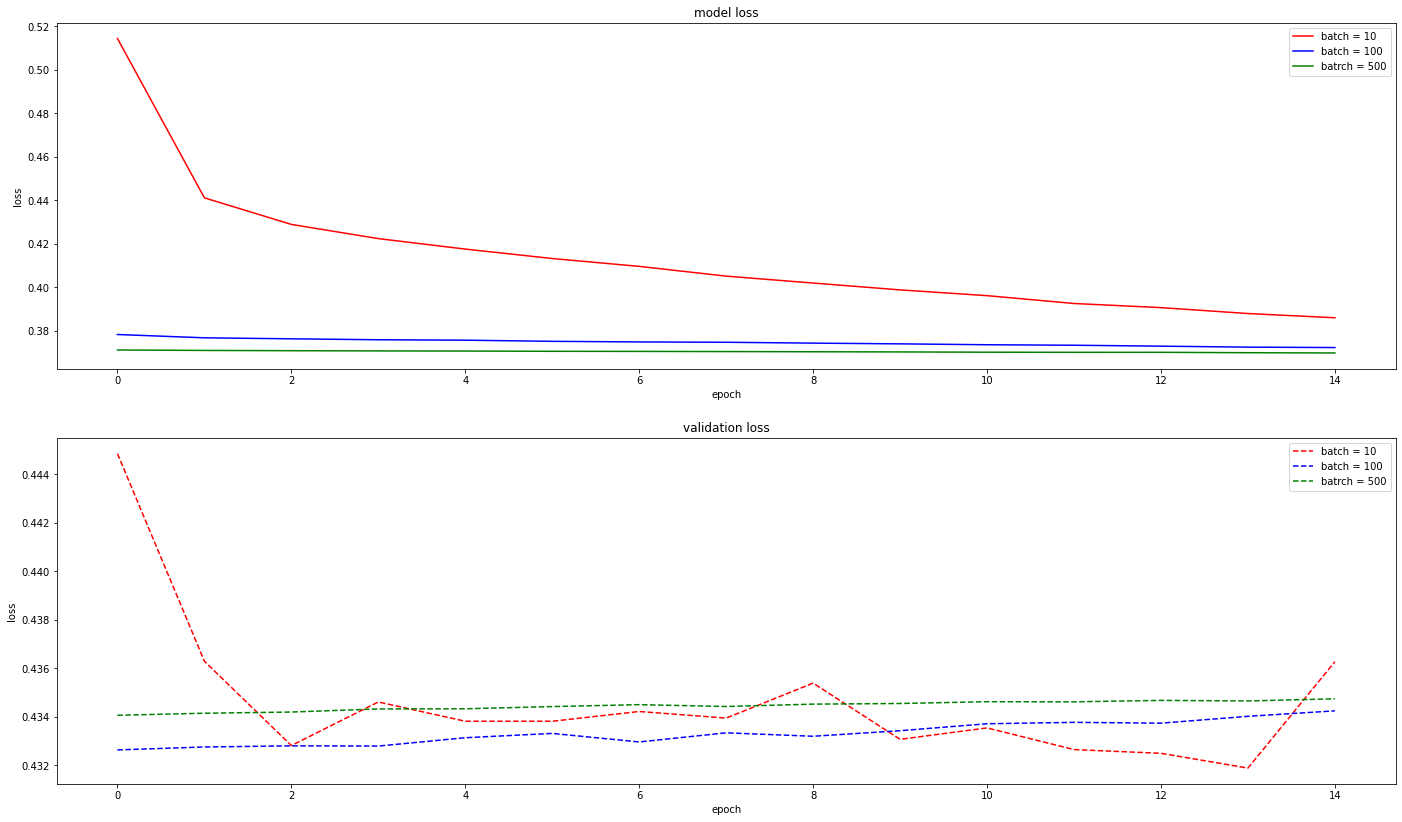

In [19]:
from matplotlib import pyplot
pyplot.figure(figsize=(24,14))
pyplot.subplot(211)
#pyplot.figure(figsize=(24,14))
pyplot.plot(history_10.history['loss'],'r')
pyplot.plot(history_100.history['loss'],'b')
pyplot.plot(history_500.history['loss'],'g')
pyplot.ylabel('loss')
pyplot.xlabel('epoch')
pyplot.legend(['batch = 10','batch = 100', 'batrch = 500'], loc='upper right')
pyplot.title('model loss')
pyplot.subplot(212)
#pyplot.figure(figsize=(24,14))
pyplot.plot(history_10.history['val_loss'],'r--')
pyplot.plot(history_100.history['val_loss'],'b--')
pyplot.plot(history_500.history['val_loss'],'g--')
pyplot.title('validation loss')
pyplot.ylabel('loss')
pyplot.xlabel('epoch')
pyplot.legend(['batch = 10','batch = 100', 'batrch = 500'], loc='upper right')
#pyplot.legend(['train batch = 50', 'validation batrch = 50','train batch = 100', 'validation batrch = 100','train batch = 500', 'validation batrch = 500'], loc='upper right')
pyplot.show()

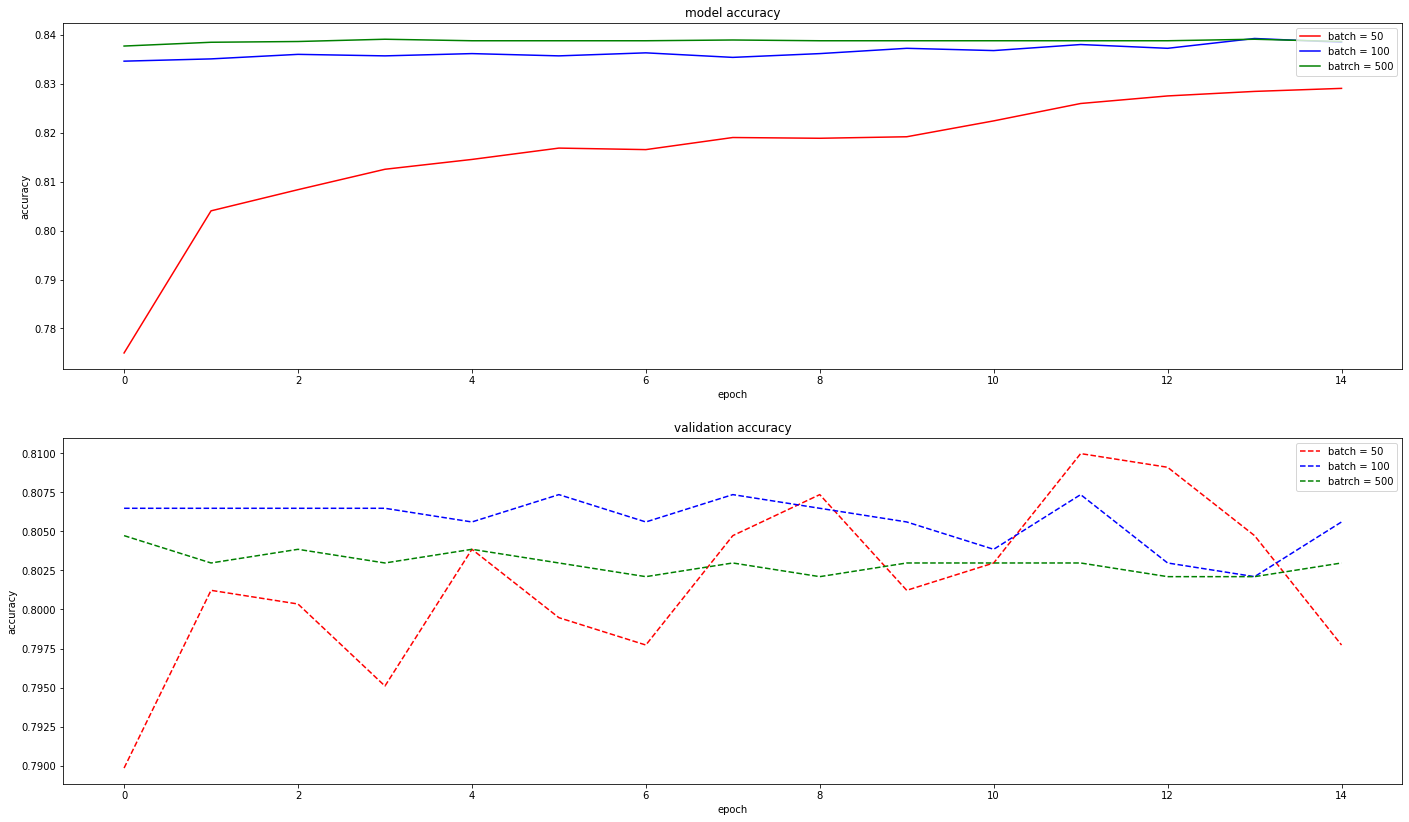

In [21]:
pyplot.figure(figsize=(24,14))
pyplot.subplot(211)
#pyplot.figure(figsize=(24,14))
pyplot.plot(history_10.history['accuracy'],'r')
pyplot.plot(history_100.history['accuracy'],'b')
pyplot.plot(history_500.history['accuracy'],'g')
pyplot.ylabel('accuracy')
pyplot.xlabel('epoch')
pyplot.legend(['batch = 50','batch = 100', 'batrch = 500'], loc='upper right')
pyplot.title('model accuracy')
pyplot.subplot(212)
#pyplot.figure(figsize=(24,14))
pyplot.plot(history_10.history['val_accuracy'],'r--')
pyplot.plot(history_100.history['val_accuracy'],'b--')
pyplot.plot(history_500.history['val_accuracy'],'g--')
pyplot.title('validation accuracy')
pyplot.ylabel('accuracy')
pyplot.xlabel('epoch')
pyplot.legend(['batch = 50','batch = 100', 'batrch = 500'], loc='upper right')
#pyplot.legend(['train batch = 50', 'validation batrch = 50','train batch = 100', 'validation batrch = 100','train batch = 500', 'validation batrch = 500'], loc='upper right')
pyplot.show()

In [25]:
pred = model.predict(padded_test)
pred = (np.round(pred)).astype(int)
pred = pred.reshape(3263)

In [26]:
my_submission = pd.DataFrame({'id': test_df.id, 'target': pred})
my_submission.to_csv('submission5.csv', index=False)